In [3]:
import numpy as np 
import pandas as pd 
import wget
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [6]:
! rm *.csv
# urls of the files
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']

# download files
for url in urls:
    filename = wget.download(url)

In [9]:
conf_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recv_df = pd.read_csv('time_series_covid19_recovered_global.csv')

dates = conf_df.columns[4:]

conf_df_long = conf_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

deaths_df_long = deaths_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')

recv_df_long = recv_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Recovered')

recv_df_long = recv_df_long[recv_df_long['Country/Region']!='Canada']

full_table = pd.merge(left=conf_df_long, right=deaths_df_long, how='left',
                      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])
full_table = pd.merge(left=full_table, right=recv_df_long, how='left',
                      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])

full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0,0.0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0,0.0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0,0.0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0,0.0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0,0.0


In [12]:
full_table = full_table[full_table['Province/State'].str.contains(',')!=True]
full_table = full_table[full_table['Country/Region']=='Russia']
full_table = full_table.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])
full_table.to_csv('covid_19_clean_complete_russia.csv', index=False)

KeyError: 'Province/State'

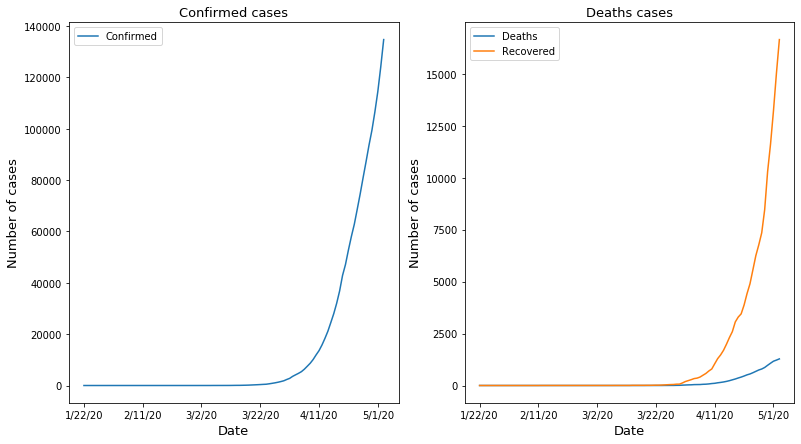

In [18]:
! rm *.png
train = full_table

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
train.plot(x='Date', y=['Confirmed'], ax=ax1)
ax1.set_title("Confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

train.plot(x='Date', y=['Deaths', 'Recovered'], ax=ax2)
ax2.set_title("Deaths cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

fig.savefig('real_cases.png')


In [21]:
days = full_table['Date'].astype('datetime64[ns]').dt.dayofyear.astype(int) - 22
table_diff = full_table.drop(columns=['Date']).diff().fillna(0)
table_diff.insert(0, 'Date', days)
table_diff.set_index('Date', drop=True, inplace=True)
full_diff = table_diff.copy()
table_diff = table_diff[50:]

current = table_diff.tail(1).copy()
current['Date'] = len(days)
current['Confirmed'] = 10581
current['Deaths'] = 76
current['Recovered'] = 1456
current.set_index('Date', drop=True, inplace=True)
full_diff.append(current)
table_diff = table_diff.append(current)

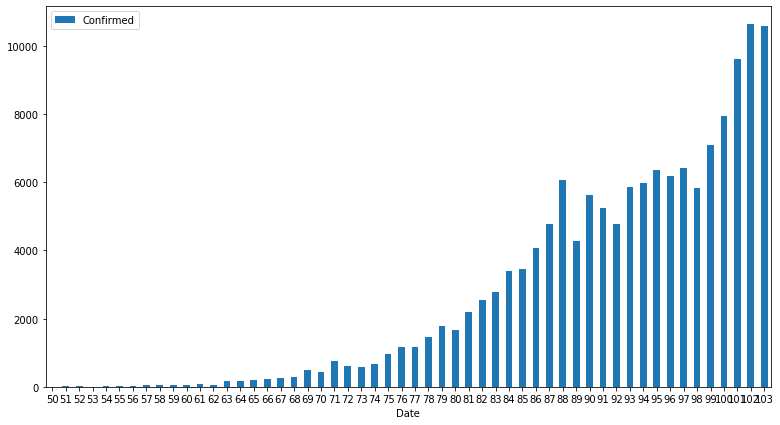

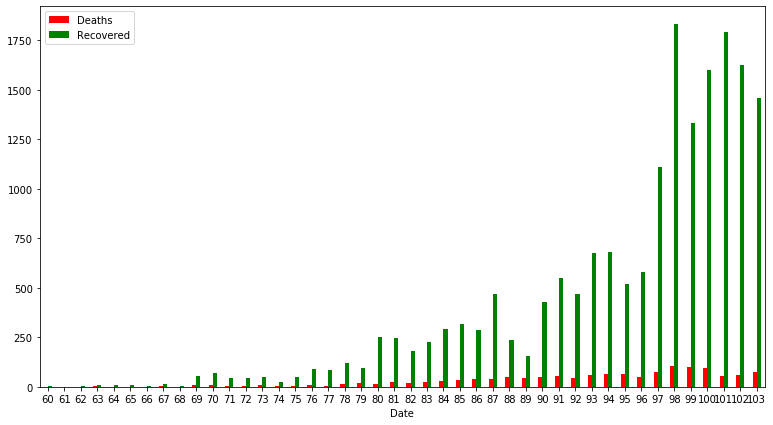

In [24]:
confirmed_diff = table_diff.drop(columns=['Deaths', 'Recovered'])

axs = confirmed_diff.plot.bar(rot=0, figsize=(13,7))
axs.figure.savefig('confirmed_dayly.png')

deaths_and_recovered_diff = table_diff.drop(columns=['Confirmed'])

axs = deaths_and_recovered_diff[10:].plot.bar(rot=0, figsize=(13,7), color=['red', 'green'])
axs.figure.savefig('deaths_and_recovered_dayly.png')

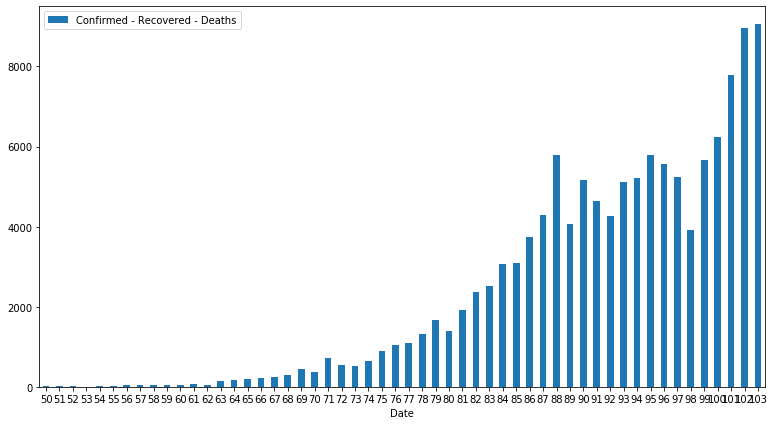

In [27]:
confirmed_minus_recoverd = pd.DataFrame()
confirmed_minus_recoverd['Confirmed - Recovered - Deaths'] = confirmed_diff.Confirmed - deaths_and_recovered_diff.Recovered  - deaths_and_recovered_diff.Deaths

axs = confirmed_minus_recoverd.plot.bar(rot=0, figsize=(13,7))
axs.figure.savefig('confirmed_minus_recoverd_and_deaths_dayly.png')


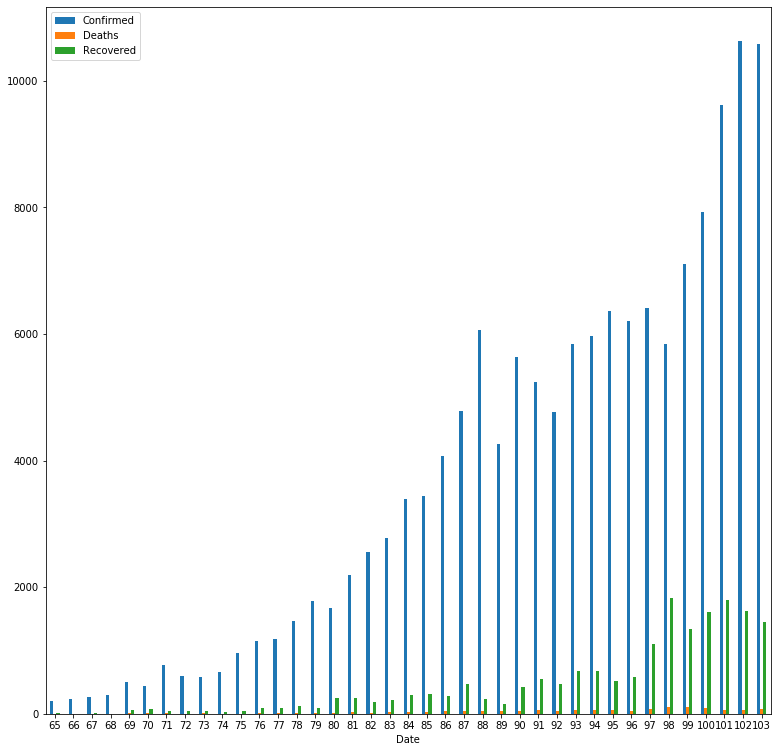

In [30]:
axs = table_diff[15:].plot.bar(rot=0, figsize=(13,13))
axs.figure.savefig('all_dayly.png')

In [33]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(100000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

In [35]:
population = float(146745098)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = full_diff.Confirmed
country_df = country_df[9:]
country_df['day_count'] = list(range(1,len(country_df)+1))

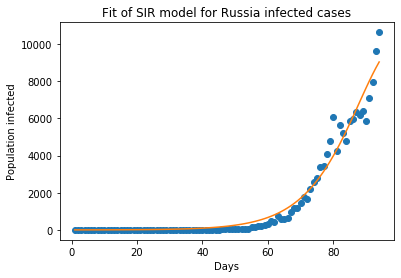

Optimal parameters: beta = 8.413790427303583  and gamma =  8.314682439245606


In [36]:
ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Russia infected cases")
plt.ylabel("Population infected")
ax1.set_yscale("log", nonposy='clip')
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])